In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import cv2 as cv
from glob import glob
from sklearn.linear_model import LinearRegression
from torch.utils.data import Dataset, DataLoader
from diffusers.models import UNet2DModel, AutoencoderTiny
from diffusers import DiffusionPipeline
from diffusers.schedulers import DDIMScheduler
from torchvision.utils import make_grid
from torchvision.transforms import functional as tvf
# from torchvision.transforms import 
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
# from torch.cuda.amp import autocast, GradScaler
from torch import autocast
from torch.amp import GradScaler

from typing import Optional, Union, List, Tuple


/home/dh2306/diffusion-examples/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class StandardDataAugmentations:
    '''
    Simple data augmentation that applies random rotation, horizontal, and vertical flips.
    '''
    
    @staticmethod
    def __call__(X: torch.Tensor, y: Optional[torch.Tensor] = None):
        
        # do not resize this time, just apply random flip and color distortions
        if torch.rand(1) > 0.5:
            X = tvf.hflip(X)
            if y is not None:
                y = tvf.hflip(y)
        
        if torch.rand(1) > 0.5:
            X = tvf.vflip(X)
            if y is not None:
                y = tvf.vflip(y)
        
        rot_angle = torch.randint(0, 4, (1,)).item()
        X = tvf.rotate(X, rot_angle * 90)
        if y is not None:
            y = tvf.rotate(y, rot_angle * 90)
    
        
        if y is not None:
            return X, y
        return X
    
class PlanetDataset(Dataset):
    
    def __init__(self, s2_filepaths: Union[List[str], Tuple[str]], ps_filepaths: Union[List[str], Tuple[str]], transforms: Optional[StandardDataAugmentations] = None):
        super().__init__()
        
        self.s2_filepaths = s2_filepaths
        self.ps_filepaths = ps_filepaths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.s2_filepaths)
        
    @staticmethod
    def _scale(
        data, 
        in_range: Union[Tuple[int, int], Tuple[float, float]]=(0, 255), 
        out_range: Union[Tuple[int, int], Tuple[float, float]]=(-1.0, 1.0)
    ) -> torch.Tensor:
        
        # scale to 0-1
        data = (data - in_range[0]) / (in_range[1] - in_range[0])
        
        # scale to out_range
        data = data * (out_range[1] - out_range[0]) - out_range[1]
        data = data.clamp(min=out_range[0], max=out_range[1])
        return data
    
    def get_s2_img(self, idx):
        
        s2_img = cv.imread(self.s2_filepaths[idx])
        s2_img = cv.cvtColor(s2_img, cv.COLOR_BGR2RGB)
        
        s2_img = torch.as_tensor(s2_img, dtype=torch.float32)
        s2_img = s2_img.permute(2, 0, 1)
        return self._scale(s2_img)
    
    def get_ps_img(self, idx, harmonize: bool=False, return_s2_img: bool=False):
        
        if return_s2_img and not harmonize:
            raise ValueError('Cannot return Sentinel-2 image when harmonize is set to False')
        
        ps_img = cv.imread(self.ps_filepaths[idx])
        ps_img = cv.cvtColor(ps_img, cv.COLOR_BGR2RGB)

        ps_img = torch.as_tensor(ps_img, dtype=torch.float32)
        ps_img = self._scale(ps_img)
        ps_img = ps_img.permute(2, 0, 1)
        return ps_img
    
    
    def __getitem__(self, idx):
        # return self.get_ps_img(idx, harmonize=True, return_s2_img=True)
        s2_img, ps_img = self.get_s2_img(idx), self.get_ps_img(idx)
        if self.transforms is not None:
            return self.transforms(s2_img, ps_img)
        else:
            return s2_img, ps_img


# s2_image_paths = glob('/Volumes/dhester_ssd/dakota_sample_training_sr_images/*/*/s2_patch_*.png')
# ps_image_paths = glob('/Volumes/dhester_ssd/dakota_sample_training_sr_images/*/*/ps_patch_*.png')
s2_image_paths = glob('../dakota_sample_training_sr_images/*/*/s2_patch_*.png')
ps_image_paths = [fp.replace('s2_patch_', 'ps_patch_').replace('.png', '_harmonized.png') for fp in s2_image_paths]


In [3]:
random.seed(1701)

unique_locations = set(path.split(os.sep)[-3] for path in s2_image_paths)
for unique_location in unique_locations:
    print(unique_location, len([path for path in s2_image_paths if path.split(os.sep)[-3] == unique_location]))

val_sites = random.sample(sorted(unique_locations), k=1)
train_sites = [site for site in unique_locations if site not in val_sites]

print(val_sites, train_sites)

17MNQ 5438
15TWH 967
13QGB 5712
11TQH 6314
17SKR 4837
15SXS 1770
18TUL 4053
13QGF 2490
10SGF 3935
16TFP 2919
['17MNQ'] ['15TWH', '13QGB', '11TQH', '17SKR', '15SXS', '18TUL', '13QGF', '10SGF', '16TFP']


In [4]:
train_s2_paths = [fp for fp in s2_image_paths if fp.split(os.sep)[-3] in train_sites]
train_ps_paths = [fp for fp in ps_image_paths if fp.split(os.sep)[-3] in train_sites]
train_dataset = PlanetDataset(train_s2_paths, train_ps_paths, transforms=StandardDataAugmentations())
print(f'Number of samples in training dataset: {len(train_dataset)}')

val_s2_paths = [fp for fp in s2_image_paths if fp.split(os.sep)[-3] in val_sites]
val_ps_paths = [fp for fp in ps_image_paths if fp.split(os.sep)[-3] in val_sites]
val_dataset = PlanetDataset(val_s2_paths, val_ps_paths)
print(f'Number of samples in validation dataset: {len(val_dataset)}')

Number of samples in training dataset: 32997
Number of samples in validation dataset: 5438


In [5]:
# device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using backed {device}')
if device.type == 'cuda' and torch.cuda.is_bf16_supported():
    print('bfloat16 is supported. Using for mixed precision.')
    mixed_precision_dtype = torch.bfloat16
else:
    print('bfloat16 not supported. Falling back to float16 for mixed precision.')
    mixed_precision_dtype = torch.float16

vae = AutoencoderTiny.from_pretrained('madebyollin/taesd')
vae.to(device)
vae = torch.compile(vae)
print(f'Total VAE parameters: {sum([p.numel() for p in vae.parameters()])}')

model = UNet2DModel(
    sample_size=32,
    in_channels=8,
    out_channels=4,
    block_out_channels=[32, 64, 128, 256],
    down_block_types=['DownBlock2D'] * 4, # + ['AttnDownBlock2D'],
    up_block_types=['UpBlock2D'] * 4, # + ['AttnUpBlock2D']
)
model.to(device)
model = torch.compile(model)

print(f'Total U-Net parameters: {sum([p.numel() for p in model.parameters()])}')

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Using backed cuda
bfloat16 is supported. Using for mixed precision.
Total VAE parameters: 2445063
Total U-Net parameters: 14159876


In [6]:
batch_size = 256
micro_batch_size = batch_size
n_epochs = 100
total_timesteps = 1000
warmup_epochs = 10
lr = 1e-4


grad_accum_steps = batch_size // micro_batch_size

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, fused=torch.cuda.is_available())
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=warmup_epochs-1)
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs - warmup_epochs)
lr_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[warmup_epochs])
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
noise_scheduler = DDIMScheduler(num_train_timesteps=total_timesteps)
scaler = GradScaler()

train_dataloader = DataLoader(train_dataset, batch_size=micro_batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=16)

losses = []
for epoch in range(1, n_epochs+1):
    
    epoch_losses = []
    with tqdm(train_dataloader, desc=f'Epoch {epoch}/{n_epochs}', unit='batch', postfix={'lr': optimizer.param_groups[0]['lr']}) as pbar:
        for i, (s2_img, ps_img) in enumerate(train_dataloader):
            
            s2_img = F.interpolate(s2_img, size=ps_img.shape[-2:], mode='bilinear')
            s2_img, ps_img = s2_img.to(device), ps_img.to(device)
            
            with autocast(device.type, dtype=mixed_precision_dtype), torch.no_grad():
                s2_latent = vae.encode(s2_img).latents
                ps_latent = vae.encode(ps_img).latents
            
            noise = torch.randn(ps_latent.shape).to(device)
            timesteps = torch.randint(0, total_timesteps, (micro_batch_size,)).to(device)
            noisy_ps_latent = noise_scheduler.add_noise(ps_latent, noise, timesteps)
            unet_input = torch.cat((noisy_ps_latent, s2_latent), dim=1)

            with autocast(device.type, dtype=mixed_precision_dtype):
                noise_pred = model(unet_input, timesteps).sample
                loss = F.mse_loss(noise, noise_pred)

            scaler.scale(loss).backward()
            epoch_losses.append(loss.item())

            if (i + 1) % grad_accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            pbar.set_postfix(lr=optimizer.param_groups[0]['lr'], loss=sum(epoch_losses) / len(epoch_losses))
            pbar.update(1)
    
    torch.save(model.state_dict(), '../models/ddim_planetscope.pt')
    losses.append(sum(epoch_losses) / len(epoch_losses))
    lr_scheduler.step()

Epoch 10/100:  34%|███▎      | 43/128 [00:36<01:11,  1.19batch/s, loss=0.174, lr=0.0001]


KeyboardInterrupt: 

50it [00:00, 64.67it/s]


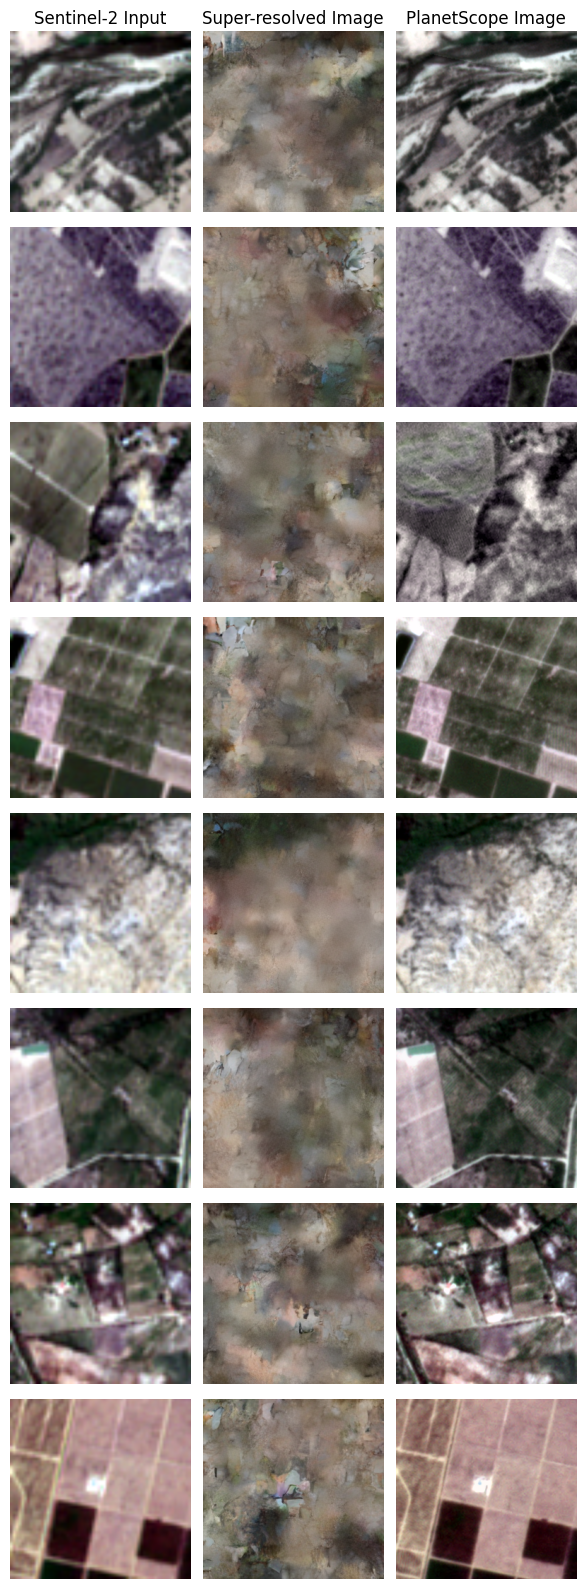

In [9]:
noise_scheduler.set_timesteps(num_inference_steps=50)

batch_size = 8
s2_img = torch.stack([val_dataset[i][0] for i in range(batch_size)], dim=0)
s2_img = F.interpolate(s2_img, size=ps_img.shape[-2:], mode='bilinear').to(device)

ps_img = torch.stack([val_dataset[i][1] for i in range(batch_size)], dim=0)

with torch.no_grad(), autocast(device.type, dtype=mixed_precision_dtype):
    s2_latent = vae.encode(s2_img).latents

x = torch.rand(s2_latent.shape, device=device)
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    noisy_latent = noise_scheduler.scale_model_input(x, t)
    model_input = torch.cat((noisy_latent, s2_latent), dim=1)
    with torch.no_grad(), autocast(device.type, dtype=mixed_precision_dtype):
        noise_pred = model(model_input, t).sample
    
    x = noise_scheduler.step(noise_pred, t, x).prev_sample

with torch.no_grad(), autocast(device.type, dtype=mixed_precision_dtype):
    output = vae.decode(x, return_dict=False)[0]

fig, axes = plt.subplots(batch_size, 3, figsize=(6, 2*batch_size))

for i, ax in enumerate(axes):
    
    # ax[0].imshow(s2_img)
    
    s2_img_display = (s2_img[i].clamp(-1, 1) + 1) / 2
    s2_img_display = s2_img_display.permute(1, 2, 0).cpu().numpy()
    ax[0].imshow(s2_img_display)
    
    output_display = (output[i].clamp(-1, 1) + 1) / 2
    output_display = output_display.permute(1, 2, 0).to(torch.float32).cpu().numpy()
    ax[1].imshow(output_display)
    
    ps_img_display = (ps_img[i].clamp(-1, 1) + 1) / 2
    ps_img_display = ps_img_display.permute(1, 2, 0).cpu().numpy()
    ax[2].imshow(ps_img_display)
    
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')

axes[0][0].set_title('Sentinel-2 Input')
axes[0][1].set_title('Super-resolved Image')
axes[0][2].set_title('PlanetScope Image')

plt.tight_layout()
plt.show()

In [ ]:
val_data